In [5]:
%load_ext autoreload
%autoreload 2

In [45]:
import pandas as pd
import numpy as np
import itertools
import mplfinance as mpf
import re
import math
from math import floor
import sys
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pickle
import datetime as dt

from dain import Adaptive_Normalizer_Layer

import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import *#Reshape, LSTM, Dense, Bidirectional, GRU, Dropout, Input, Embedding, MultiHeadAttention, LayerNormalization, Conv1D, GlobalMaxPooling1D
from fit_one_cycle import OneCycleScheduler
from lr_finder import LRFinder

from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


df_1T = pd.read_parquet('df_CNN_LSTM_1T.parquet').reset_index().reset_index().set_index('datetime', drop=True)
df_5T = pd.read_parquet('df_CNN_LSTM_5T.parquet')
df_15T = pd.read_parquet('df_CNN_LSTM_15T.parquet')
df_1H = pd.read_parquet('df_CNN_LSTM_1H.parquet')
df_4H = pd.read_parquet('df_CNN_LSTM_4H.parquet')
df_1B = pd.read_parquet('df_CNN_LSTM_1B.parquet').fillna(0)

In [46]:
# Define the data generator function
def normalize_and_yield(batch_data, batch_targets):
    # Convert to np.array
    batch_data = np.asarray(batch_data)
    batch_targets = np.asarray(batch_targets)
    
    # Normalize
    # for i in range(batch_data.shape[1]):
    #     a = batch_data[:, i, :, :]
    #     scaler = StandardScaler()
    #     batch_data[:, i, :, :] = scaler.fit_transform(a.reshape(-1, a.shape[-1])).reshape(a.shape[0], a.shape[1], a.shape[2])

    batch_data = batch_data.astype('float32')
    batch_data = np.split(batch_data, 6, axis=1)
    batch_data = [element.squeeze(axis=1) for element in batch_data]

    return np.asarray(batch_data), batch_targets.astype('float32')


def data_generator(data, window_size, batch_size, indices):
    batch_data = []
    batch_targets = []
    i=0
    for index in indices:
        dt_index = df_1T.iloc[index].name
        input_sequences = np.array([
            df_1T.loc[:dt_index-pd.Timedelta(minutes=1)][-360:].fillna(0).drop(columns='index').values.astype('float32'),
            df_5T.loc[:dt_index-pd.Timedelta(minutes=5)][-360:].fillna(0).values.astype('float32'),
            df_15T.loc[:dt_index-pd.Timedelta(minutes=15)][-360:].fillna(0).values.astype('float32'),
            df_4H.loc[:dt_index-pd.Timedelta(hours=4)][-360:].fillna(0).values.astype('float32'),
            df_4H.loc[:dt_index-pd.Timedelta(hours=4)][-360:].fillna(0).values.astype('float32'),
            df_1B.loc[:dt_index.normalize()-pd.Timedelta(days=1)][-360:].fillna(0).values.astype('float32')
        ])

        # Extract the target high and low values
        target_high = df_1T[index : index+151].high_es.max()
        target_low = df_1T[index : index+151].low_es.min()

        # Add the input sequence and targets to the batch
        batch_data.append(input_sequences)
        batch_targets.append([target_high, target_low])
        print(i, len(indices)) if i % batch_size == 0 else None
        i += 1
        
    return normalize_and_yield(batch_data, batch_targets)


                
# Set the window size and batch size
window_size = 362880 # minutes in 252 days (1 year of trading days)
batch_size = 256
num_features = df_1T.shape[1]-1

# Set the split ratios
train_ratio = 0.8
test_ratio = 0.1

# set random seed for the shuffle function
np.random.seed(42)

# Get the indices for training, validation, and testing splits
# Filter the indices to exclude those with insufficient historical data
indices = df_1T.loc[(df_1T.index.hour == 9) & (df_1T.index.minute == 30) & (df_1T.index.dayofweek < 5) & (df_1T['index'] > 681587)]['index'].to_numpy()
X, y = data_generator(df_1T, window_size, batch_size, indices)

# Get the total number of samples and calculate the split index
num_samples = X.shape[1]
split_index = int(num_samples * 0.8)

# Shuffle the indices
indices = np.random.permutation(num_samples)

# Split the array based on the shuffled indices
X_train = list(X[:, indices[:split_index], :, :])
y_train = y[indices[:split_index]]
X_test = list(X[:, indices[split_index:], :, :])
y_test = y[indices[split_index:]]

0 3121
256 3121
512 3121
768 3121
1024 3121
1280 3121
1536 3121
1792 3121
2048 3121
2304 3121
2560 3121
2816 3121
3072 3121


In [32]:
# Reshape X_train to a 2D array
X_train = np.asarray(X_train)
orig_shape = X_train.shape

# Fit the scaler to the data and transform X_train
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape((-1, X_train.shape[-1])))

# Reshape X_train_scaled_2d back to the original shape
X_train = list(X_train.reshape(orig_shape))

In [49]:
# Define the Transformer model

# Set the window size and number of features

# Define the input layer
inputs_1T = Input(shape=(360, num_features), batch_size=batch_size)
inputs_5T = Input(shape=(360, num_features), batch_size=batch_size)
inputs_15T = Input(shape=(360, num_features), batch_size=batch_size)
inputs_1H = Input(shape=(360, num_features), batch_size=batch_size)
inputs_4H = Input(shape=(360, num_features), batch_size=batch_size)
inputs_1B = Input(shape=(360, num_features), batch_size=batch_size)

main_inputs = [inputs_1T, inputs_5T, inputs_15T, inputs_1H, inputs_4H, inputs_1B]

# Apply batch normalization to each input
inputs_1T_norm = BatchNormalization()(inputs_1T)
inputs_5T_norm = BatchNormalization()(inputs_5T)
inputs_15T_norm = BatchNormalization()(inputs_15T)
inputs_1H_norm = BatchNormalization()(inputs_1H)
inputs_4H_norm = BatchNormalization()(inputs_4H)
inputs_1B_norm = BatchNormalization()(inputs_1B)

inputs = [inputs_1T_norm, inputs_5T_norm, inputs_15T_norm, inputs_1H_norm, inputs_4H_norm, inputs_1B_norm]

# Define the Convolutional model
timeframes = [1, 5, 15, 60, 240, 1440]  # in minutes
conv_outputs = []
for timeframe, inputs in zip(timeframes, inputs):
    conv_layer = Conv1D(filters=128, kernel_size=5, strides=1, activation='sigmoid', kernel_initializer='glorot_uniform')(inputs)
    conv_layer = BatchNormalization()(conv_layer)
    conv_layer = Dropout(0.5)(conv_layer)

    # Add LSTM layers
    #x = LSTM(32, return_sequences=True)(conv_layer)
    #x = Dropout(0.5)(x)
    
    # Add transformer layers
    x = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=4, kernel_initializer='glorot_uniform')(conv_layer, conv_layer, conv_layer)
    #x = Dropout(0.5)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x = Dropout(0.5)(x)
    conv_outputs.append(x)
    
# Concatenate the output
conv_output = Concatenate(axis=1)(conv_outputs)

# Reshape the output to have a 3D shape
#conv_output = Reshape((-1, len(timeframes) * 32))(conv_output)

# Define the output layer
#output1 = TimeDistributed(Dense(1), name='output1')(conv_output)
#output2 = TimeDistributed(Dense(1), name='output2')(conv_output)
output1 = GlobalAveragePooling1D()(conv_output)
output2 = GlobalAveragePooling1D()(conv_output)

output = Concatenate()([output1, output2])
output = Dense(2)(output)

# Define the model with two outputs
model = Model(inputs=main_inputs, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mae', metrics=['mse'], run_eagerly=True)

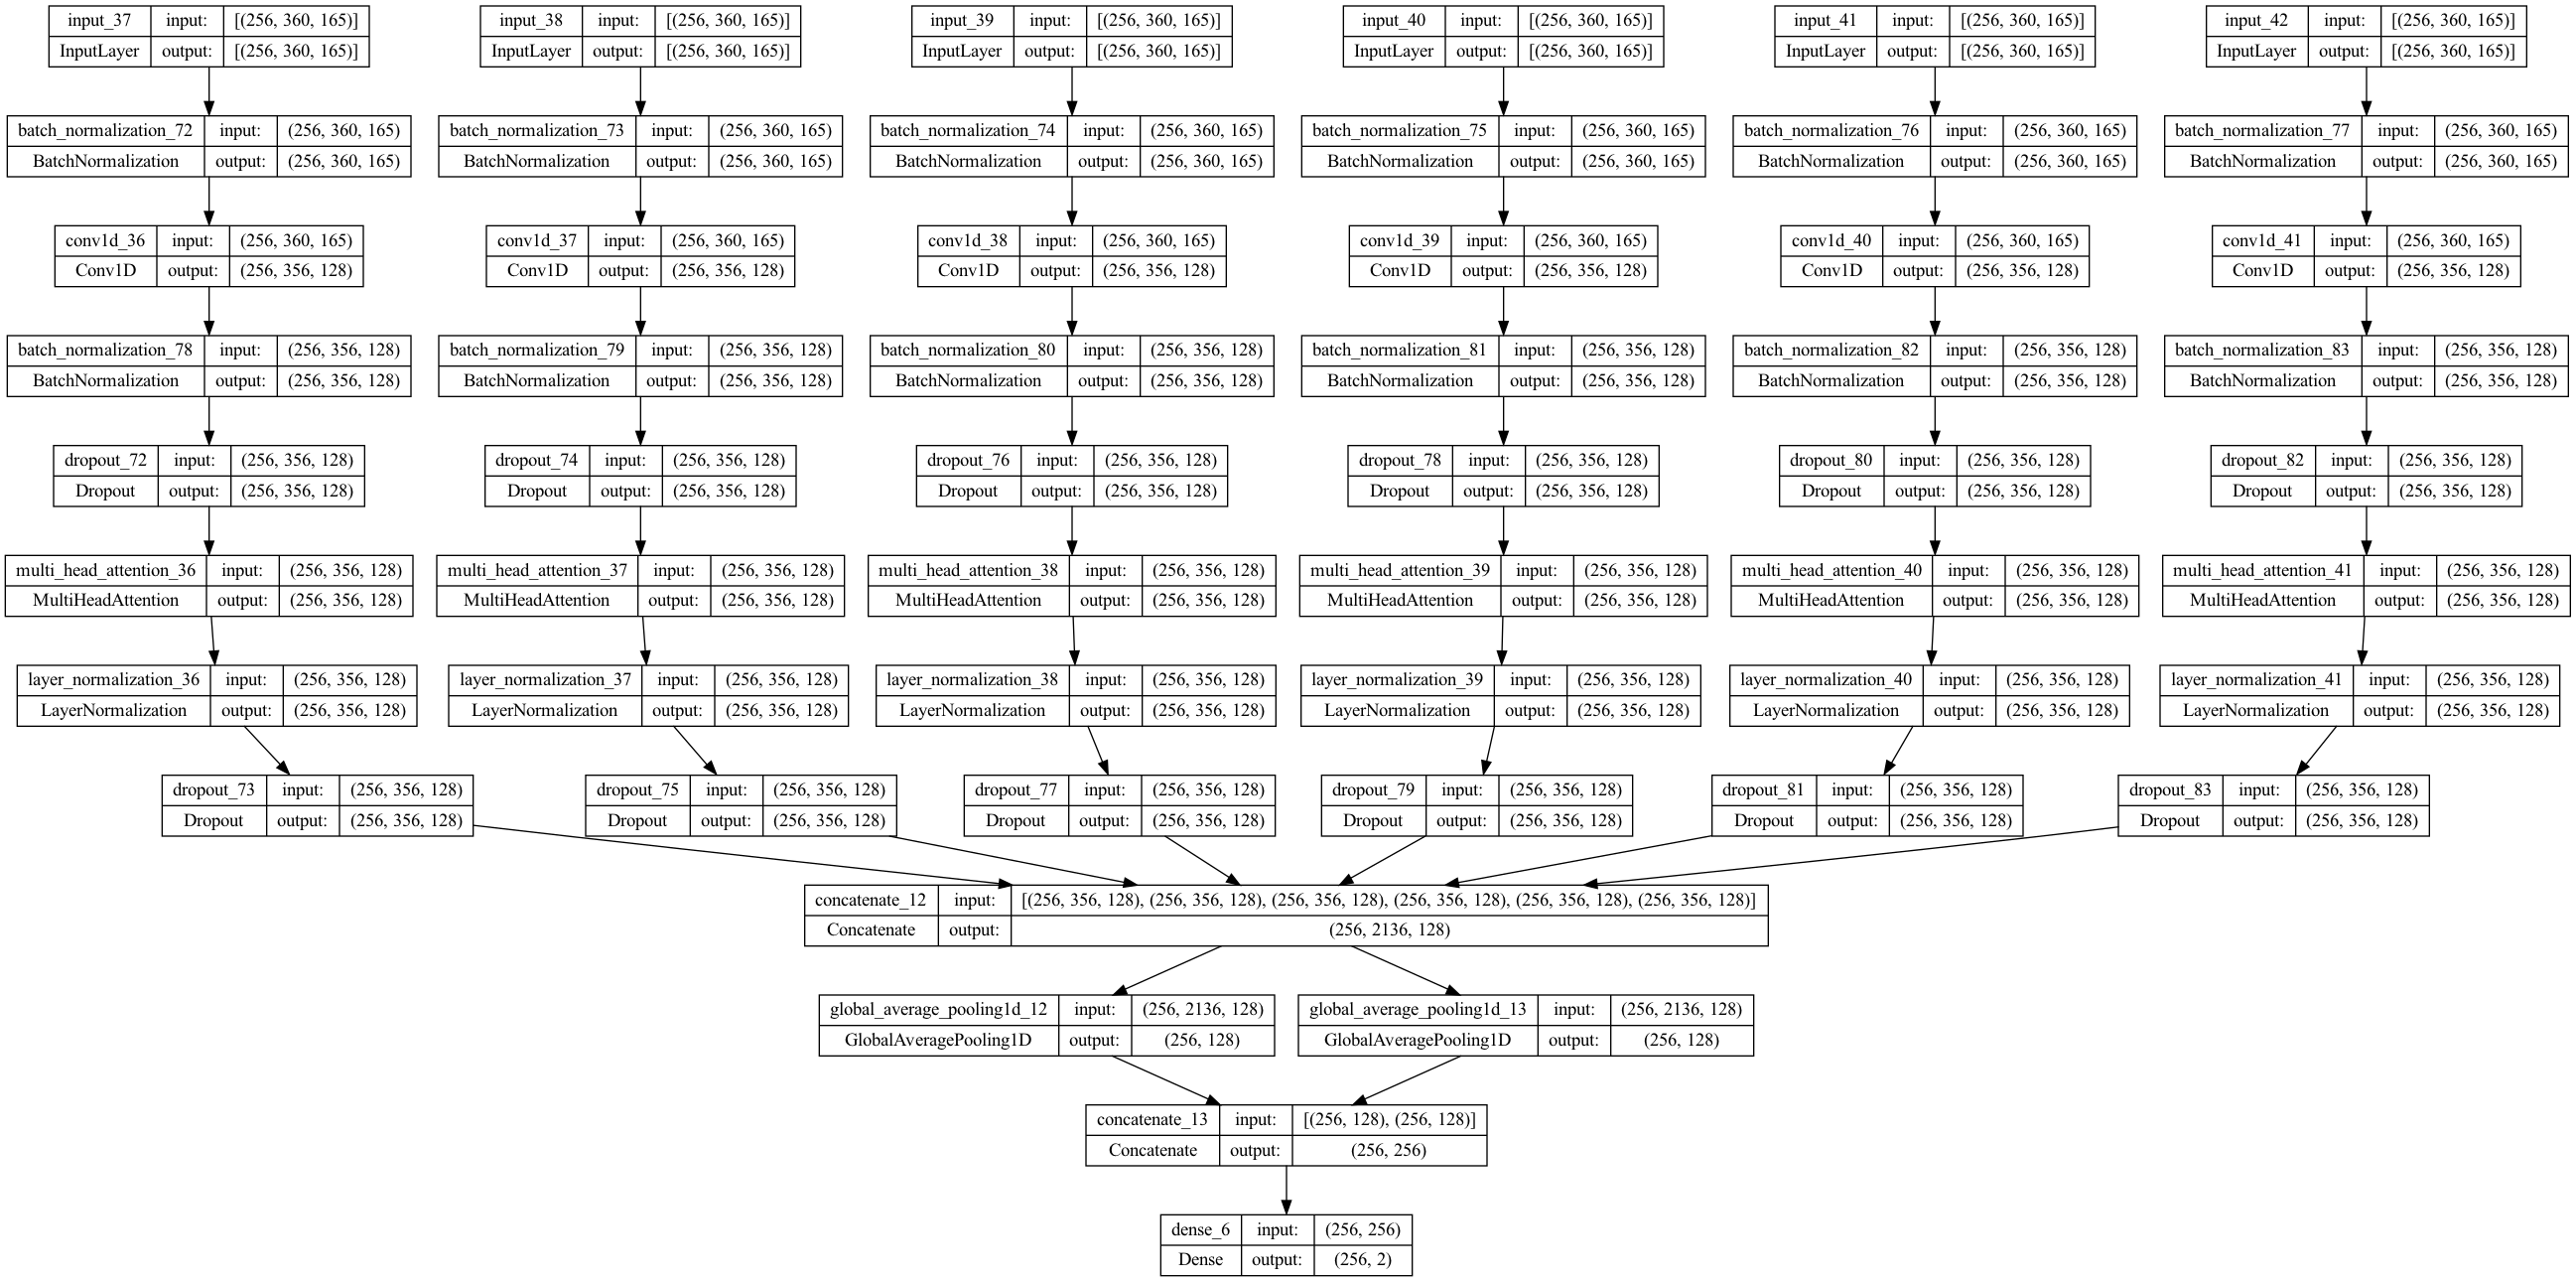

In [50]:
#model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### layer activations
#### tensorboard

Epoch 1/30
71/71 [==============================] - ETA: 0s - loss: 6358418.5000 - mae: 2295.2542

/Users/kush/Documents/DS/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - 82s 1s/step - loss: 6358418.5000 - mae: 2295.2542 - val_loss: 3877200.2500 - val_mae: 1694.4888
Epoch 2/30
71/71 [==============================] - 82s 1s/step - loss: 2600282.0000 - mae: 1269.6906 - val_loss: 1137531.6250 - val_mae: 826.1571
Epoch 3/30
71/71 [==============================] - 83s 1s/step - loss: 686844.6250 - mae: 557.9178 - val_loss: 459860.5625 - val_mae: 448.3141
Epoch 4/30
71/71 [==============================] - 83s 1s/step - loss: 202657.2656 - mae: 290.6902 - val_loss: 337875.5625 - val_mae: 511.1852
Epoch 5/30
71/71 [==============================] - 83s 1s/step - loss: 103153.7031 - mae: 236.3031 - val_loss: 220689.9375 - val_mae: 379.7784
Epoch 6/30
71/71 [==============================] - 87s 1s/step - loss: 61634.3516 - mae: 186.1239 - val_loss: 36555.0547 - val_mae: 146.1252
Epoch 7/30
71/71 [==============================] - 86s 1s/step - loss: 47284.0508 - mae: 160.3726 - val_loss: 127315.8125 - val_mae: 317.9423

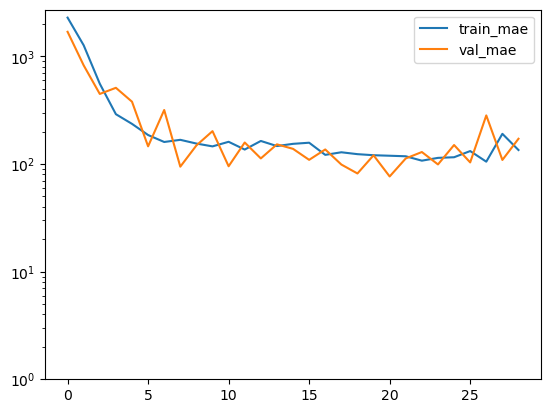

In [44]:
epochs = 30
lr = 1e-2

train_steps_per_epoch = len(X_train[0]) // batch_size

lr_schedule = OneCycleScheduler(lr, train_steps_per_epoch)
lr_finder = LRFinder()

log_dir = "logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# Define the Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor for early stopping
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the best model weights based on the monitored metric
)

# Define the ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint(
    'best_model.h5',  # Filepath to save the best model
    monitor='val_loss',  # Metric to monitor for saving the best model
    save_best_only=True  # Save only the best model based on the monitored metric
)

history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.1,
                    callbacks=[lr_schedule, tensorboard_callback, early_stopping, checkpoint])

# Plot the training and validation loss and MAE
plt.semilogy(history.history['mae'], label='train_mae')
plt.semilogy(history.history['val_mae'], label='val_mae')
plt.ylim(ymin=1)  # Set the y-axis minimum value to 0
plt.legend()
plt.show()

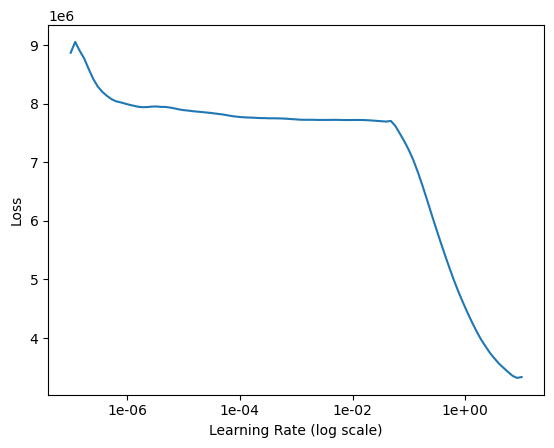

In [12]:
lr_finder.plot()

In [11]:
test_generator = data_generator(df_1T, window_size, batch_size, test_indices)
test_steps = len(test_indices) // batch_size
# Generate predictions for the test set
predictions = model.predict(test_generator, steps=test_steps)
test_generator = data_generator(df_1T, window_size, batch_size, test_indices)
model.evaluate(test_generator, steps=test_steps)

#dates = df.iloc[test_indices].index.strftime("%Y-%m-%d")[:576]

# Extract the predicted high and low values
predicted_high = predictions[:, 0]
predicted_low = predictions[:, 1]

# Reset the test data generator to get actual values
test_generator = data_generator(df_1T, window_size, batch_size, test_indices, test=True)

# Get the actual high and low values
actual_high = []
actual_low = []
dates = df_1T.iloc[test_indices].index
x_test = []
for i in range(test_steps):
    x, batch_targets = next(test_generator)
    x_test.append(x)
    actual_high.extend(batch_targets[:, 0])
    actual_low.extend(batch_targets[:, 1])
    
    
# actual_high = np.exp(actual_high) * open_prices
# actual_low = np.exp(actual_low) * open_prices
# predicted_high = np.exp(predicted_high) * open_prices
# predicted_low = np.exp(predicted_low) * open_prices

# Print the individual predictions with actual values
# for i in range(len(predicted_high)):
#     print(f"Sample {i+1} - {dates[i]} - Predicted/Actual High: {predicted_high[i]:.2f}, {actual_high[i]:.2f} Predicted/Actual Low: {predicted_low[i]:.2f}, {actual_low[i]:.2f}")


9/9 [==============================] - 7s 835ms/step - loss: 11393.7939 - mae: 81.8167


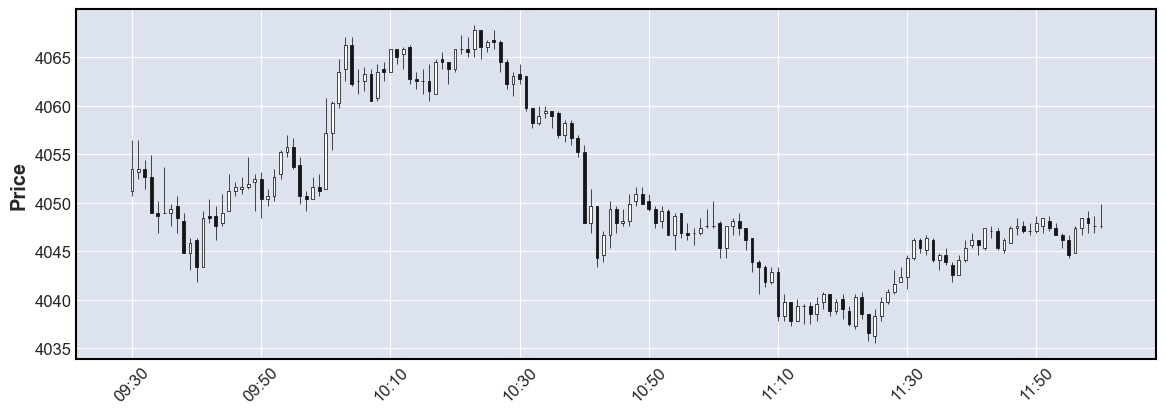

In [52]:
mpf.plot(df_es.loc['2023-01-17'].between_time('9:30', '12:00'), type='candle', figsize=(15,5))

In [54]:
df_es.loc['2023-01-17'].between_time('9:30', '12:00').high.max()

4068.302354

In [28]:
for d,ph,h,pl,l in zip(test_indices, predictions[:, 0], actual_high, predictions[:, 1], actual_low):
    print(f'{df_1T.iloc[d].name.date()} PH: {ph:.2f}, H: {h:.2f}, PL: {pl:.2f}, L: {l:.2f}')

2021-11-12 PH: 4639.76, H: 4758.83, PL: 4600.56, L: 4726.28
2013-09-26 PH: 1636.91, H: 1638.21, PL: 1623.71, L: 1627.60
2022-06-27 PH: 4150.77, H: 4013.89, PL: 4114.92, L: 3974.84
2015-12-24 PH: 1969.35, H: 2054.85, PL: 1953.36, L: 2048.35
2015-10-01 PH: 1968.68, H: 1907.55, PL: 1952.68, L: 1883.92
2016-09-29 PH: 2198.89, H: 2189.38, PL: 2181.50, L: 2179.02
2022-03-23 PH: 4615.04, H: 4584.57, PL: 4575.98, L: 4558.53
2017-03-07 PH: 2496.53, H: 2406.55, PL: 2476.53, L: 2397.94
2023-01-18 PH: 4211.35, H: 4066.54, PL: 4174.40, L: 4006.05
2016-04-21 PH: 2042.55, H: 2106.31, PL: 2025.54, L: 2097.02
2022-10-28 PH: 4099.32, H: 3947.40, PL: 4064.51, L: 3879.30
2017-06-22 PH: 2469.79, H: 2476.57, PL: 2450.35, L: 2467.93
2011-11-15 PH: 1157.92, H: 1168.83, PL: 1149.54, L: 1158.10
2017-11-10 PH: 2653.65, H: 2621.38, PL: 2632.73, L: 2615.02
2014-12-18 PH: 1983.57, H: 2006.32, PL: 1967.44, L: 1992.06
2023-01-10 PH: 4106.65, H: 3967.23, PL: 4071.57, L: 3929.17
2014-08-29 PH: 1907.33, H: 1953.09, PL: 